In [16]:
##basic chatbot using groq and LLama##
from typing import TypedDict,Annotated,List
from langgraph.graph import add_messages,StateGraph,END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage,HumanMessage
from dotenv import load_dotenv
from PIL import Image
import io
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display


load_dotenv()


True

In [26]:
llm_model = ChatGroq(model = 'llama-3.1-8b-instant')
search_tools = TavilySearchResults(max_results=2)
tools = [search_tools]

llm_with_tool = llm_model.bind_tools(tools = tools)

class BasicChatState(TypedDict):
    messages: Annotated[List[str],add_messages]

def chatNode(state:BasicChatState):
    return {
        "messages": [llm_with_tool.invoke(state["messages"])] 
    }

In [13]:
###testing how llm_with_tool replies
response = llm_with_tool.invoke("Weather right now in Mumbai?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mtcx3d8y2', 'function': {'arguments': '{"query":"Current weather in Mumbai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 567, 'total_tokens': 588, 'completion_time': 0.036675061, 'prompt_time': 0.037267725, 'queue_time': -0.069194156, 'total_time': 0.073942786}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_0f5c9bc037', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2d860a7d-7165-4afb-ab39-17a0f6bd67cd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Current weather in Mumbai'}, 'id': 'mtcx3d8y2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 567, 'output_tokens': 21, 'total_tokens': 588})

In [10]:
##experimenting with AI message
response.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Mumbai weather now'},
  'id': '7s7fwmxc1',
  'type': 'tool_call'}]

In [27]:
def tools_router(state:BasicChatState):

    last_message = state["messages"][-1] ##getting the last message in the list
    ##check if the last message has attribute tool calls##
    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return "toolNode"
    else:
        return END

In [28]:
## building the tool node ###
from langgraph.prebuilt import ToolNode
toolNode = ToolNode(tools=tools,messages_key="messages") 
## this node checks for the last ai message and excutes the tool ##
##specified the messages key in state
##default is "messages"

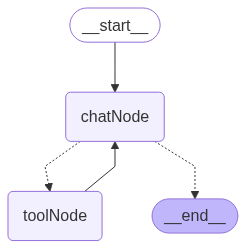

In [29]:
graph = StateGraph(BasicChatState)
graph.add_node("chatNode",chatNode)
graph.add_node("toolNode",toolNode)
graph.add_conditional_edges("chatNode",tools_router)
graph.set_entry_point("chatNode")
graph.add_edge("toolNode","chatNode")
app = graph.compile()
png = app.get_graph().draw_mermaid_png()
display(Image(png))


In [32]:
while True:
    user_input = input("User: ")
    if (user_input in ["exit","end"]):
        break
    else:
        result = app.invoke(

            {"messages":[HumanMessage(content=user_input)]} ##start with the Human message
        )

        print(result)


User:  What is the current weather in mumbai?


{'messages': [HumanMessage(content='What is the current weather in mumbai?', additional_kwargs={}, response_metadata={}, id='2e5dc430-2998-477d-be33-b2da1368f308'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8q046fd9r', 'function': {'arguments': '{"query":"mumbai current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 287, 'total_tokens': 308, 'completion_time': 0.037198491, 'prompt_time': 0.020519612, 'queue_time': 0.04859979800000001, 'total_time': 0.057718103}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6c07fa60-5693-4390-a53b-5b701ee80dbb-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'mumbai current weather'}, 'id': '8q046fd9r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 287, 'output_tokens': 21, 'total_tokens': 308}), ToolMessage(

User:  Exit


{'messages': [HumanMessage(content='Exit', additional_kwargs={}, response_metadata={}, id='ff540321-0b77-4ab1-b059-58dcb4f4d9f7'), AIMessage(content='<function=tavily_search_results_json>{"query": "exit"}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 279, 'total_tokens': 294, 'completion_time': 0.02387824, 'prompt_time': 0.016661476, 'queue_time': 0.048479830999999994, 'total_time': 0.040539716}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_0f5c9bc037', 'finish_reason': 'stop', 'logprobs': None}, id='run-12456704-8030-4330-bdb5-8622662a3cac-0', usage_metadata={'input_tokens': 279, 'output_tokens': 15, 'total_tokens': 294})]}


User:  end
